In [2]:
# | hidden: true
# | echo: false
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# some personal style settings to make the plots look nice
# and save some space in the notebook
plt.style.use("../style.mplstyle")

## Permutation Tests

There is one more frequently applicable sampling-based method that is super helpful in statistical inference: permutation (or randomization) tests.

Permutation tests, like the bootstrap, are non-parametric -- meaning they do not rely on assumptions about the underlying distribution of the data. Like the bootstrap, permutation tests rely on resampling -- only instead of resampling with replacement, we resample without replacement.

Say we have two samples, $X$ and $Y$, and we want to test if they have different underlying distributions (e.g. different means). Then, our null hypothesis ($H_0$) is that the two samples are drawn from the same distribution.

So, we can combine the two samples into one larger sample, $Z = X \cup Y$, and then randomly split $Z$ into two new samples, $X'$ and $Y'$, of the same size as the original samples. We can then compute the test statistic (e.g. the difference in means) for the new samples and repeat this process many times to build a distribution of test statistics under the null hypothesis.

The only assumption we need to make is that the two samples are **exchangeable** under the null hypothesis. This means that, if the null hypothesis is true, the two samples could be shuffled without changing the underlying distribution.

`np.random.permutation` is a useful function for this. It randomly permutes the elements of an array, which we can use to create our new samples. Let's define a function to perform a permutation test 

In [3]:
#| code-fold: show
def permutation_test(test_func, x, y, num_permutations=10000, rng=None, one_sided=True):
    # Compute the observed test statistic
    observed_stat = test_func(x, y)

    # Combine the two samples
    combined = np.concatenate([x, y])
    count = 0

    if rng is None:
        rng = np.random.default_rng()
    for _ in range(num_permutations):
        # Permute the combined array
        permuted = rng.permutation(combined)

        # Split the permuted array into two new samples
        x_perm = permuted[:len(x)]
        y_perm = permuted[len(x):]

        # Compute the test statistic for the permuted samples
        permuted_stat = test_func(x_perm, y_perm)

        # Compare the permuted statistic to the observed statistic
        if one_sided:
            if permuted_stat >= observed_stat:
                count += 1
        else:
            if np.abs(permuted_stat) >= np.abs(observed_stat):
                count += 1

    # Compute the p-value
    p_value = count / num_permutations
    return p_value


We can apply this to our NBA data to test if SGA and Giannis have different scoring rates. This is quite similar to the bootstrap hypothesis test we did in the previous lecture, but instead of resampling with replacement, we will resample without replacement.

Both versions work, but the permutation test tends to be more powerful. 

:::{.callout-note title="Statistical Power"}
Power
: The probability of correctly rejecting the null hypothesis when it is false. 

A more "powerful" test is more likely to detect a true effect. The power of a test is often written as $1 - \beta$, where $\beta$ is the probability of a Type II error (failing to reject the null hypothesis when it is false).

We usually want our tests to have high power, so we can detect true effects when they exist. We try to balance this against the risk of **falsely** rejecting the null hypothesis (Type I error) when it is actually true.
:::


In [4]:
#| code-fold: show

### Data import and preparation ###
sga_df = pd.read_csv("../data/sga-stats-24-25.csv")
giannis_df = pd.read_csv("../data/giannis-stats-24-25.csv")
# combine the dataframes and clean up the data
sga_df["player"] = "Shai Gilgeous-Alexander"
giannis_df["player"] = "Giannis Antetokounmpo"
compare_df = pd.concat([sga_df, giannis_df], ignore_index=True)
# filter out rows where the player did not play or was inactive
compare_df = compare_df.replace(
    {"Did Not Dress": np.nan, "Inactive": np.nan, "Did Not Play": np.nan, "": np.nan}
)
compare_df.dropna(subset=["PTS"], inplace=True)
# convert PTS to float/numeric and Date to datetime
compare_df["PTS"] = compare_df["PTS"].astype(float)
compare_df["Date"] = pd.to_datetime(compare_df["Date"])

rng = np.random.default_rng(42) 
# run the permutation test
p_value = permutation_test(
    lambda x, y: np.mean(x) - np.mean(y), # lambda functions can be used inline without naming the function
    compare_df[compare_df["player"] == "Shai Gilgeous-Alexander"]["PTS"],
    compare_df[compare_df["player"] == "Giannis Antetokounmpo"]["PTS"],
    rng=rng
)
print(
    f"P-value for the hypothesis that SGA scores more points than Giannis: {p_value:.4f}"
)


P-value for the hypothesis that SGA scores more points than Giannis: 0.0336


## There is really only one test!

The more statistics you learn and the more you are exposed to work in quantitative fields, the more you will see a wide variety of complicated statistical techniques and methods. 

Ultimately they all represent the same process:

1. Compute a test statistic on the observed data.
2. Choose a null hypothesis / model. Either specify the null distribution explicitly or use a simulation-based method to generate a distribution of test statistics under the null hypothesis.
3. Compute a p-value by comparing the observed test statistic to the distribution of test statistics under the null hypothesis. 

Most of the literature in classical statistics focuses on mathematically deriving analytical solutions for 2 and 3. All of the fancy named statistical tests you see are variations with different test statistics and null hypotheses. 

Check out [this blog post](https://allendowney.blogspot.com/2016/06/there-is-still-only-one-test.html) by Allen Downey for more on this idea and explanation of the advantages of simulation-based methods for hypothesis testing.

### Example: Two-sample t-test

One of the most common statistical tests is the independent two-sample $t$-test, which tests if two independent samples have different means. This is used in many fields, including psychology, medicine, and social sciences -- basically anywhere you want to compare two groups.

Remembering the $t$-test is not an important point of this course -- we introduce it here because it is used so frequently in practice that it is worth understanding the basic idea behind it (and that it is just a special case of the general hypothesis testing framework we have been discussing).

We learned already that (by the Central Limit Theorem) as the sample size increases, the sampling distribution of the sample mean becomes approximately normal, even if the underlying distribution is not normal. The *exact* distribution of the sample mean, however, is called the **t-distribution**. It is quite like the normal distribution, but has heavier tails (more likely to produce extreme values). See the plots below for an illustration of how the t-distribution converges to the standard normal distribution as the sample size increases.

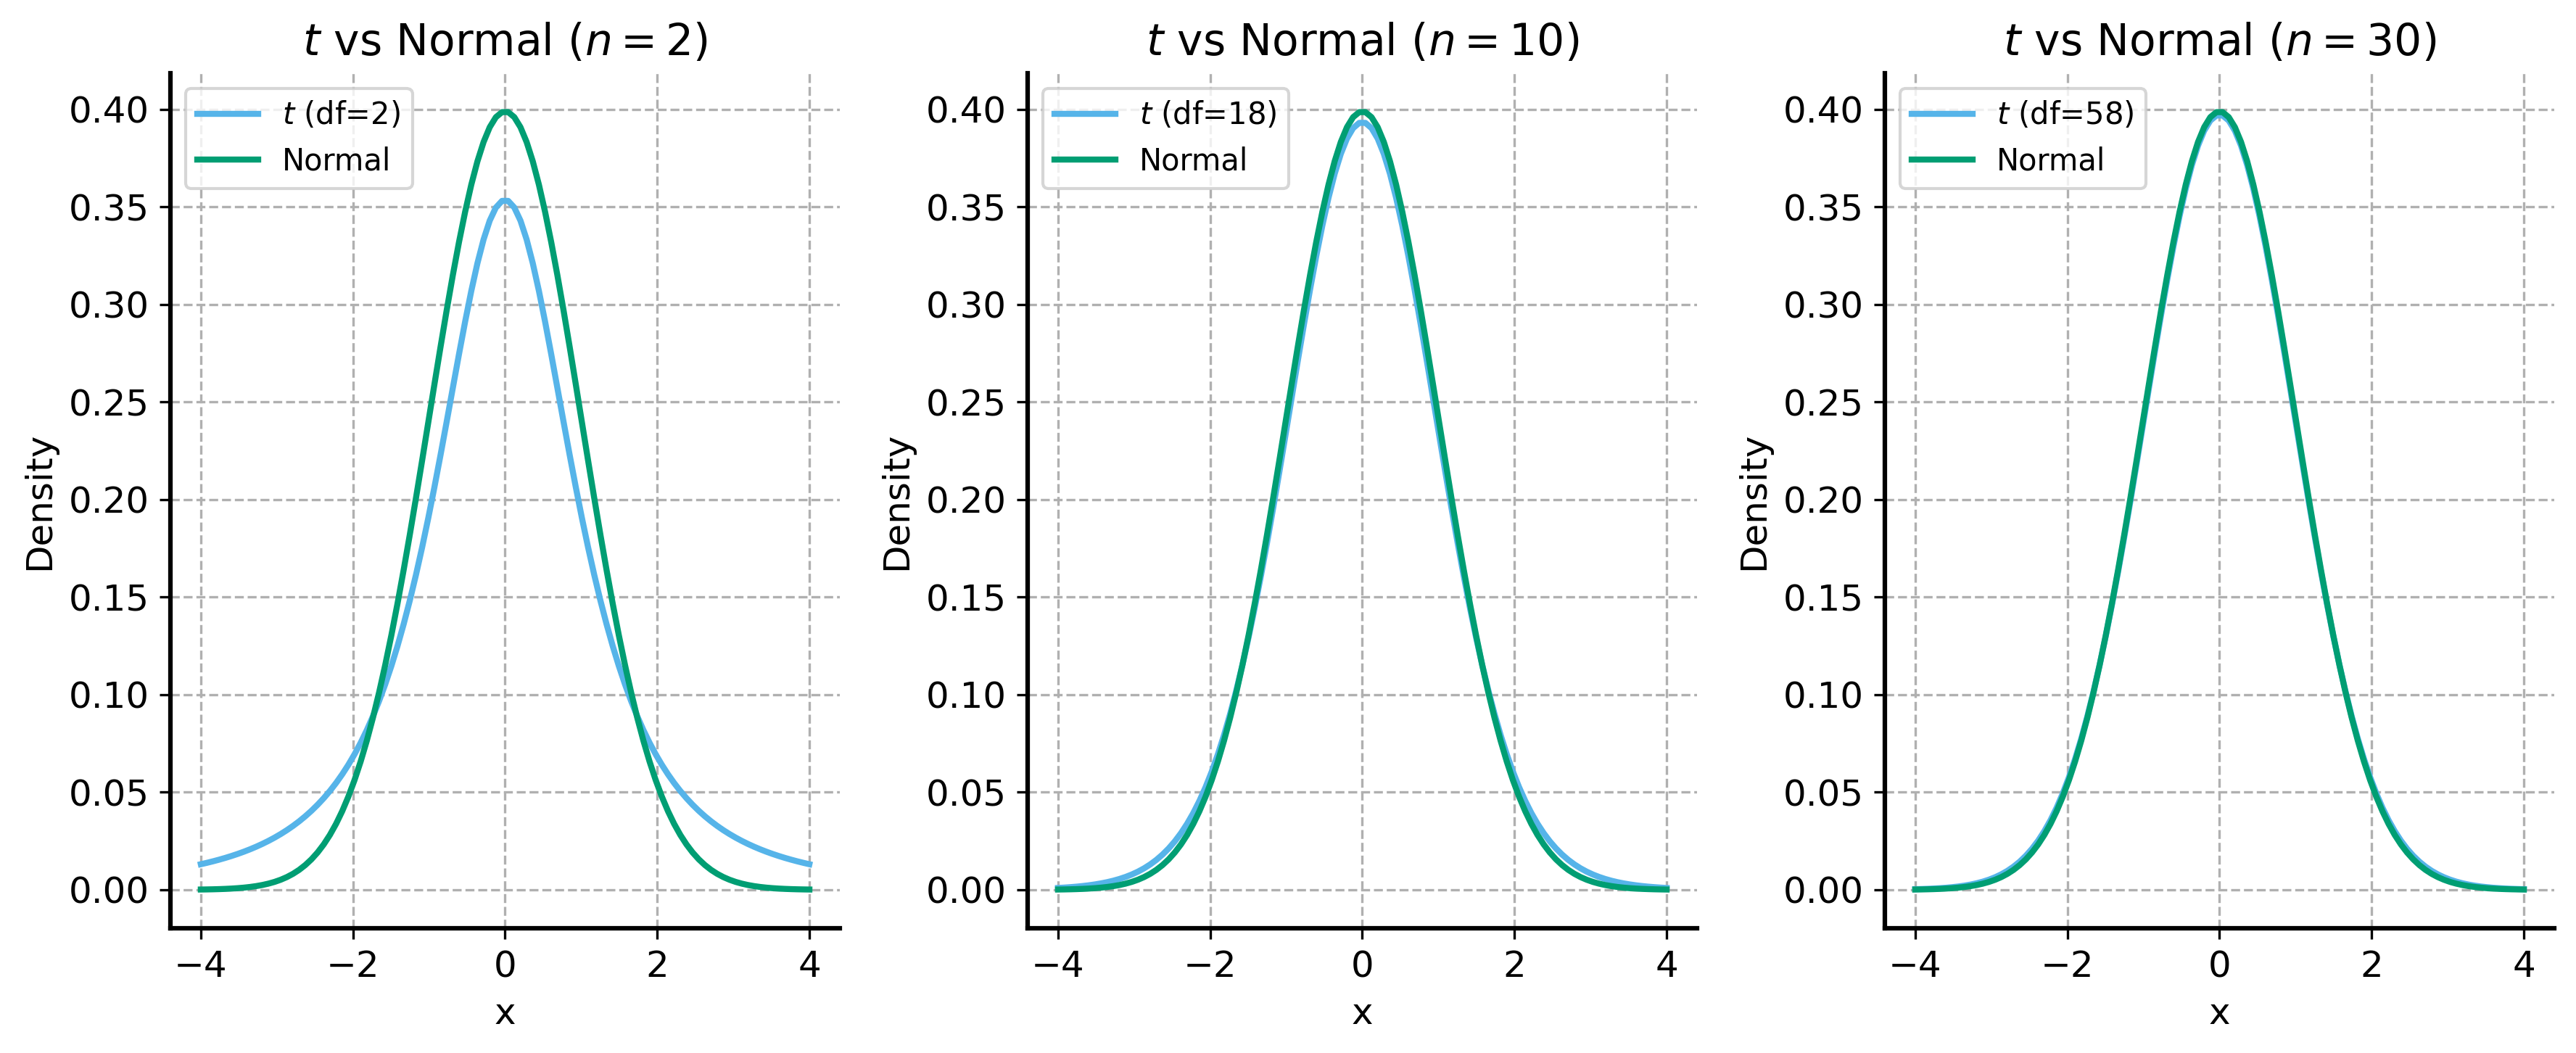

In [5]:
x = np.linspace(-4, 4, 100)
stats.t.pdf(
    x,
    df=10,
    loc=0,
    scale=1
)
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
# Plotting the t-distribution and normal distribution for comparison
for i, sample_size in enumerate([2, 10, 30]):
    df = 2 * sample_size - 2
    sns.lineplot(
        x=x,
        y=stats.t.pdf(x, df=df, loc=0, scale=1),
        label=f"$t$ (df={df})",
        ax=ax[i]
    )
    sns.lineplot(
        x=x,
        y=stats.norm.pdf(x, loc=0, scale=1),
        label="Normal",
        ax=ax[i]
    )
    ax[i].grid(True)
    ax[i].set_title(f"$t$ vs Normal ($n={sample_size}$)")
    ax[i].set_xlabel("x")
    ax[i].set_ylabel("Density")
    sns.move_legend(ax[i], loc="upper left")
    
plt.tight_layout()
plt.show()

Let's create two independent samples from uniform distributions with different means and equal variance. We'll perform a two-sample t-test to see if they are significantly different. In other words, we will test the null hypothesis that the two samples have the same mean against the alternative hypothesis that they have different means.

We'll use the built-in `scipy.stats.ttest_ind` function to perform the t-test, but we will also manually compute the t-statistic and p-value to illustrate the process. We will also sample from the t-distribution to compare our results. Finally, we will perform a permutation test to see how it compares.

In [6]:
#| code-fold: show

# simulate a t-distribution
rng = np.random.default_rng(43)  # set a random seed for reproducibility

# take two samples from different uniform distributions
samples_a = rng.uniform(low=-1, high=3, size=10)
samples_b = rng.uniform(low=-3, high=1, size=10)

t_parametric = stats.ttest_ind(
    samples_a,
    samples_b,
    equal_var=True
)
print(f"Parametric t-test statistic: {t_parametric.statistic:.4f}, p-value: {t_parametric.pvalue:.6f}")

# calculate the t-statistic manually

diff_means = np.mean(samples_a) - np.mean(samples_b)
# assume they have the same variance -- use the "pooled" or averaged variance
pooled_var = (np.var(samples_a, ddof=1) + np.var(samples_b, ddof=1))
pooled_std_error = np.sqrt(pooled_var / len(samples_a))
t_stat= diff_means / pooled_std_error
t_abs = np.abs(t_stat)
print(f"Manual t-statistic: {t_stat:.4f}")
# two-tailed test: 1 - (CDF(t_statistic) - CDF(-t_statistic))
p_value_t_pdf = 1 - (stats.t.cdf(
    t_abs,
    df=len(samples_a) + len(samples_b) - 2
) - stats.t.cdf(
    -t_abs,
    df=len(samples_a) + len(samples_b) - 2
))
print(f"Theoretical p-value from PDF of t: {p_value_t_pdf:.6f}")

# Sample from a t-distribution
num_samples = 10000
t_samples = rng.standard_t(
    df=len(samples_a) + len(samples_b) - 2,
    size=num_samples
)
# calculate the p-value from the simulated t-distribution
p_value_simulated = np.mean(np.abs(t_samples) >= t_abs)
print(f"Simulated p-value by sampling from t: {p_value_simulated:.6f}")


## # Permutation test for t-statistic
def permutation_test_t(
    x, y, num_permutations=10000, rng=None,
):
    # Compute the observed t-statistic
    observed_stat = stats.ttest_ind(x, y, equal_var=True).statistic

    # Combine the two samples
    combined = np.concatenate([x, y])

    if rng is None:
        rng = np.random.default_rng()
    permuted_stats = []
    for _ in range(num_permutations):
        # Permute the combined array
        permuted = rng.permutation(combined)

        # Split the permuted array into two new samples
        x_perm = permuted[:len(x)]
        y_perm = permuted[len(x):]

        # Compute the t-statistic for the permuted samples
        permuted_stat = stats.ttest_ind(x_perm, y_perm, equal_var=True).statistic

        # Compare the permuted statistic to the observed statistic
        permuted_stats.append(permuted_stat)
    # Compute the p-value
    permuted_stats = np.array(permuted_stats)
    p_value = np.mean(np.abs(permuted_stats) >= np.abs(observed_stat))

    return permuted_stats, p_value

# Run the permutation test
permuted_stats, p_value = permutation_test_t(
    samples_a,
    samples_b,
    num_permutations=10000,
    rng = rng
)
print(f"Permutation test p-value: {p_value:.6f}")

Parametric t-test statistic: 2.6958, p-value: 0.014783
Manual t-statistic: 2.6958
Theoretical p-value from PDF of t: 0.014783
Simulated p-value by sampling from t: 0.014400
Permutation test p-value: 0.015700


All of these results are quite similar! It's not a coincidence -- they are all effectively the same test. We're comparing the observed t-statistic to the distribution of t-statistics under the null hypothesis that the two samples are drawn from the same distribution.

This might be easier to appreciate visually:

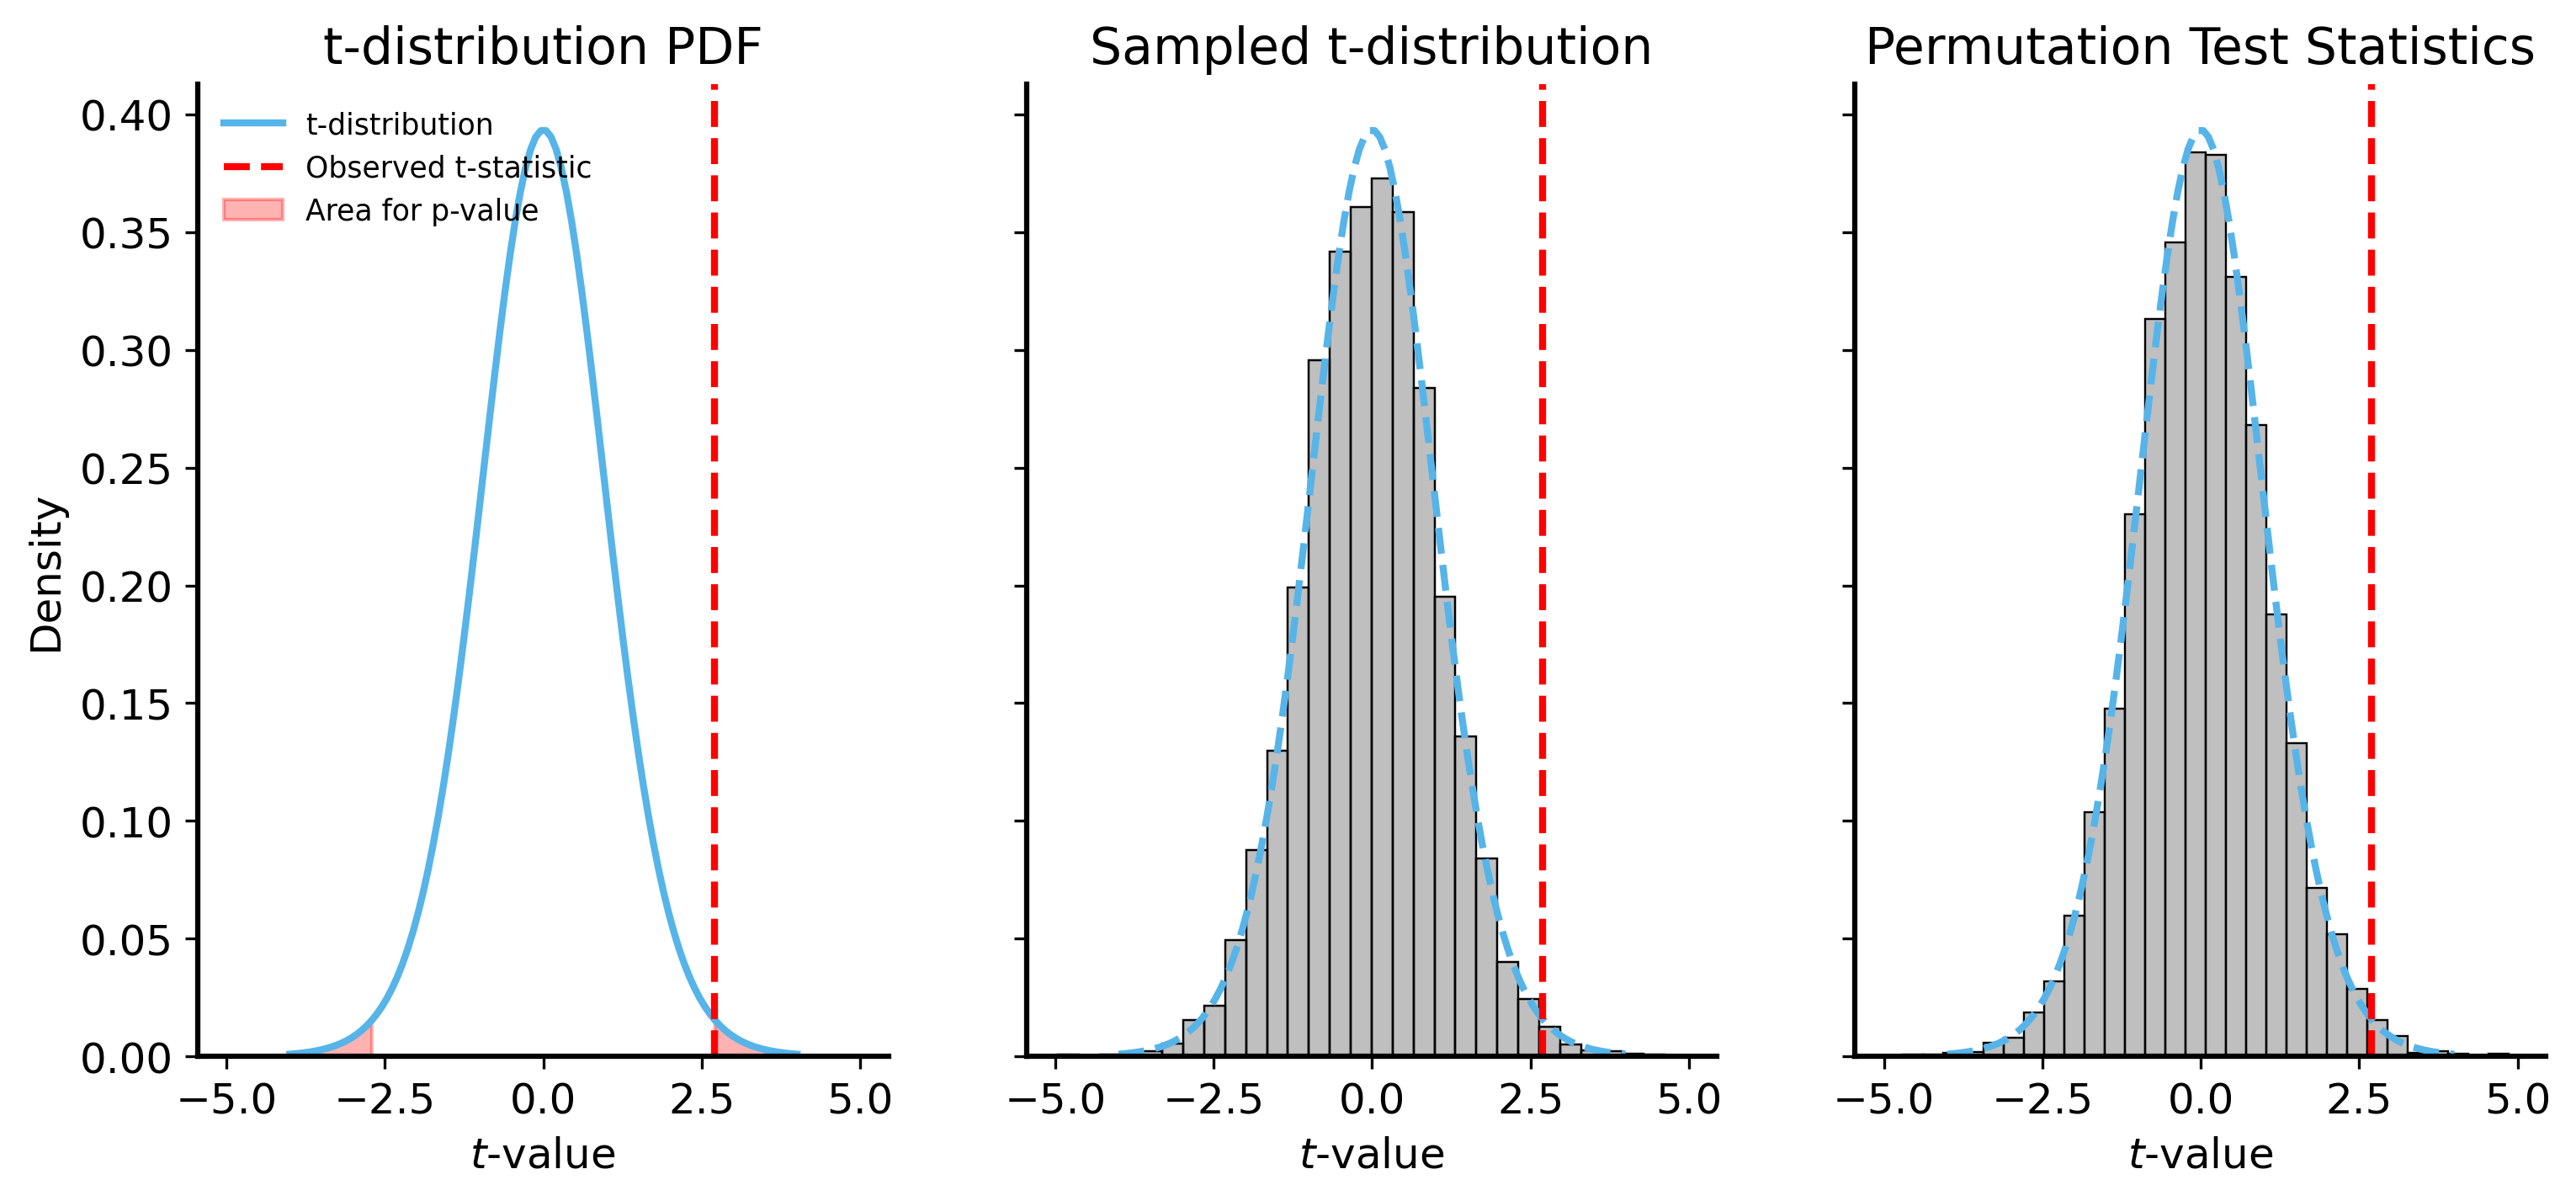

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5), sharey=True, sharex=True)
# plot the t-distribution and highlight the observed t-statistic
ax[0].plot(x, stats.t.pdf(x, df=len(samples_a) + len(samples_b) - 2), label='t-distribution')
ax[0].axvline(t_abs, color='red', linestyle='--', label='Observed t-statistic')
ax[0].fill_between(
    x,
    stats.t.pdf(x, df=len(samples_a) + len(samples_b) - 2),
    where=np.abs(x) >= t_abs,
    alpha=0.3,
    color='red',
    label='Area for p-value'
)
ax[0].set_title('t-distribution PDF')
ax[0].set_xlabel('$t$-value')
ax[0].set_ylabel('Density')
ax[0].legend(loc="upper left", fontsize='x-small', frameon=False)

sns.histplot(t_samples, bins=30, ax=ax[1], stat="density", color="gray", alpha=0.5)
ax[1].plot(x, stats.t.pdf(x, df=len(samples_a) + len(samples_b) - 2), linestyle='--', label='t-distribution')   
ax[1].axvline(t_abs, color='red', linestyle='--', label='Observed t-statistic')
ax[1].set_title('Sampled t-distribution')
ax[1].set_xlabel('$t$-value')
ax[1].set_ylabel('Density')

sns.histplot(permuted_stats, bins=30, ax=ax[2], stat="density", color="gray", alpha=0.5)
ax[2].plot(x, stats.t.pdf(x, df=len(samples_a) + len(samples_b) - 2), linestyle='--', label='t-distribution')
ax[2].axvline(t_abs, color='red', linestyle='--', label='Observed t-statistic')
ax[2].set_title('Permutation Test Statistics')
ax[2].set_xlabel('$t$-value')
ax[2].set_ylabel('Density')
plt.show()

See how close the sampling distributions are to the theoretical t-distribution? This is why all the tests are so similar.